In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# long short strategy on BTC

In [25]:
#step1
def load_data(csv_name):
    df = pd.read_csv(csv_name, parse_dates=['timestamp'])
    return df

#step 2
def create_features(df):
    df['day'] = df.timestamp.dt.weekday
    return df

#step 3
def to_position(day_int):
    if day_int >= 4:
        return 1
    else:
        return -1


def generate_signals(df):
    df['entry'] = df.day.apply(to_position)
    return df



#step4
def calculate_returns(df):
    #step4.1
    df['returns'] = np.log(df.close/df.close.shift(1))
    #step 4.2
    df['strategy_returns'] = df.entry * df.returns

    #step4.3
    df['strat_total'] = df.strategy_returns.cumsum()

    df['bench_total'] = df.returns.cumsum()

    return df




def run_backtest(csv_name, init_invest):
    df = csv_name

    df = create_features(df)

    df = generate_signals(df)

    df= calculate_returns(df)
    #plot strategy vs bench
    df.set_index('timestamp')
    df[['strat_total','bench_total']].plot()
    plt.show()

    strat_prof = np.exp(df.strat_total.values[-1])
    bench_prof = np.exp(df.bench_total.values[-1])

    print(f"Strategy initial invest: ${init_invest} ending: ${init_invest*strat_prof}")
    print(f"Bench initial invest: ${init_invest} ending: ${init_invest *bench_prof}")

    return df

In [26]:
btc = pd.read_csv("btc_master.csv", parse_dates=['timestamp'])
btc = btc.drop("Unnamed: 0", axis=1)

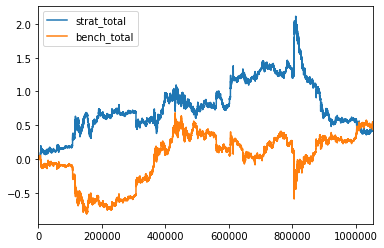

Strategy initial invest: $1000 ending: $1537.893919856499
Bench initial invest: $1000 ending: $1706.1209964412762


,volume,ticks,status,open,low,high,cost,close,timestamp,day,to_position,entry,returns,strategy_returns,strat_total,bench_total
0,0.000000,1.535756e+09,ok,7025.0,7025.0,7025.0,0.0,7025.0,2018-08-31 23:00:00,4,1,1,NaN,NaN,NaN,NaN
1,0.000000,1.535756e+09,ok,7025.0,7025.0,7025.0,0.0,7025.0,2018-08-31 23:01:00,4,1,1,0.000000,0.000000,0.000000,0.000000
2,0.000000,1.535757e+09,ok,7025.0,7025.0,7025.0,0.0,7025.0,2018-08-31 23:02:00,4,1,1,0.000000,0.000000,0.000000,0.000000
3,0.000000,1.535757e+09,ok,7025.0,7025.0,7025.0,0.0,7025.0,2018-08-31 23:03:00,4,1,1,0.000000,0.000000,0.000000,0.000000
4,0.000000,1.535757e+09,ok,7025.0,7025.0,7025.0,0.0,7025.0,2018-08-31 23:04:00,4,1,1,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054807,0.166959,1.599001e+09,ok,11979.0,11979.0,11979.0,2000.0,11979.0,2020-09-01 22:56:00,1,-1,-1,-0.000042,0.000042,0.430956,0.533680
1054808,0.000000,1.599001e+09,ok,11979.0,11979.0,11979.0,0.0,11979.0,2020-09-01 22:57:00,1,-1,-1,0.000000,-0.000000,0.430956,0.533680
1054809,0.219560,1.599001e+09,ok,11979.5,11976.5,11979.5,2630.0,11977.0,2020-09-01 22:58:00,1,-1,-1,-0.000167,0.000167,0.431123,0.533513
1054810,3.423265,1.599001e+09,ok,11976.5,11976.5,11985.5,41010.0,11985.5,2020-09-01 22:59:00,1,-1,-1,0.000709,-0.000709,0.430414,0.534222


In [27]:
btc = create_features(btc)
btc['to_position'] = btc.day.apply(lambda x: to_position(x))
# btc = generate_signals(btc)
# btc = calculate_returns(btc)
run_backtest(btc, 1000)

# moving average strategy on BTC

In [28]:
class BackTestSA:
    '''
    backtesting class for all single asset strategies, 
    columns must include the following :
    close: float
    timestamp: date
    '''

    def __init__(self, dataframe, max_holding):
        if not isinstance(dataframe, pd.DataFrame):
            raise TypeError('Dataframe must be pandas df')

        #vertical barrier variable
        self.max_holding = max_holding
        self.max_holding_limit = max_holding

        self.df = dataframe

        #trade variables
        self.open_pos = False
        self.entry_price = None
        self.direction = None
        self.target_price = None
        self.stop_price = None

        #barrier multipliers
        self.ub_mult = 1.005
        self.lb_mult = 0.995
        
        #special case of vertical barrier
        self.end_date = self.df.timestamp.values[-1]

        self.returns_series = []


    def open_long(self, price):
        '''
        
        :param price: price we open long at
        :return: populates trade variables from constructor with relevant variables
        '''
        self.open_pos = True
        self.direction = 1
        self.entry_price = price
        self.target_price = price * self.ub_mult
        self.stop_price = price * self.lb_mult
        self.returns_series.append(0)

    def open_short(self, price):
        '''
        
        :param price: price we open short at
        :return: populates trade variables from constructor with relevant variables
        '''
        self.open_pos = True
        self.direction = -1
        self.entry_price = price
        self.target_price = price * self.lb_mult
        self.stop_price = price * self.ub_mult
        self.returns_series.append(0)

    def reset_variables(self):
        '''
        resets the variables after we close a trade
        '''
        self.open_pos = False
        self.entry_price = None
        self.direction = None
        self.target_price = None
        self.stop_price = None
        self.max_holding = self.max_holding_limit

    def close_position(self, price):
        '''
        
        :param price: price we are exiting trade at 
        :return: appends the trade pnl to the returns series 
        and resets variables 
        '''
        pnl = (price/self.entry_price-1)*self.direction
        self.returns_series.append(pnl)
        self.reset_variables()


    def generate_signals(self):
        '''
        
        use this function to make sure generate signals has been included in the child class 
        '''
        if 'entry' not in self.df.columns:
            raise Exception('You have not created signals yet')



    def monitor_open_positions(self, price, timestamp):
        #check upper horizontal barrier for long positions
        if price >= self.target_price and self.direction == 1:
            self.close_position(price)
        #check lower horizontal barrier for long positions
        elif price <= self.stop_price and self.direction == 1:
            self.close_position(price)
        # check lower horizontal barrier for short positions
        elif price <= self.target_price and self.direction == -1:
            self.close_position(price)
        # check upper horizontal barrier for short positions
        elif price >= self.stop_price and self.direction == -1:
            self.close_position(price)
        # cehck special case of vertical barrier
        elif timestamp == self.end_date:
            self.close_position(price)
        # check vertical barrier
        elif self.max_holding <= 0:
            self.close_position(price)
        # if all above conditions not true, decrement max holding by 1 and append a zero to returns column
        else:
            self.max_holding = self.max_holding - 1
            self.returns_series.append(0)


    def run_backtest(self):
        #signals generated from child class
        self.generate_signals()
        
        #loop over dataframe 
        for row in self.df.itertuples():
            #if we get a long signal and do not have open position open a long
            if row.entry == 1 and self.open_pos is False:
                self.open_long(row.close)
            #if we get a short position and do not have open position open a sort
            elif row.entry == -1 and self.open_pos is False:
                self.open_short(row.close)
            #monitor open positions to see if any of the barriers have been touched, see function above
            elif self.open_pos:
                self.monitor_open_positions(row.close, row.timestamp)
            else:
                self.returns_series.append(0)

In [29]:
class MovingAverageStrategy(BackTestSA):

    def __init__(self, dataframe, max_holding):
        super().__init__(dataframe, max_holding)



    def generate_signals(self):

        df = self.df

        df['ma_20'] = df.close.rolling(20).mean()
        df['ma_50'] = df.close.rolling(50).mean()

        df['ma_diff'] = df.ma_20 - df.ma_50

        df['longs'] = ((df.ma_diff > 0) & (df.ma_diff.shift(1) < 0))*1
        df['shorts'] = ((df.ma_diff < 0) & (df.ma_diff.shift(1) > 0)) * -1

        df['entry'] = df.longs + df.shorts

        self.df = df


    def show_performace(self):
        rets = np.array(self.returns_series)

        cum_rets = rets.cumsum()

        plt.plot(cum_rets)
        plt.show()


In [30]:
btc = pd.read_csv("btc_master.csv", parse_dates=['timestamp'])
btc = btc.drop("Unnamed: 0", axis=1)

In [31]:
ma = MovingAverageStrategy(btc, 150)

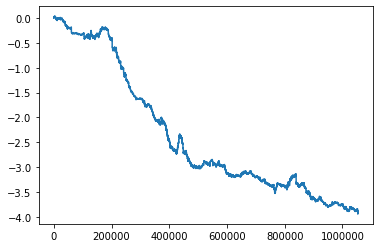

In [32]:
ma.run_backtest()
ma.show_performace()

# MACD

In [38]:

#suggested by support from Oscar

btc = pd.read_csv("btc_master.csv", parse_dates=['timestamp'])
btc = btc.drop("Unnamed: 0", axis=1)

class MCDA(BackTestSA):

    def __init__(self, dataframe, max_holding):
        super().__init__(dataframe, max_holding)



    def generate_signals(self):

        df = self.df

        df['ema26'] = df.close.ewm(span=26).mean()
        df['ema12'] = df.close.ewm(span=12).mean()
        df['MACD'] = df['ema12'] - df['ema26']
        df["action"] = df.MACD.rolling(window = 9).mean()

        #Take difference between macd and macd signal, used to find crossovers
        df["diff"] = df["MACD"] - df["action"]

        #Sell signal
        df['shorts'] = ((df["diff"]  > 0) & (df["diff"].shift(1) < 0)) * -1
        #Buy signal
        df['longs'] = ((df["diff"]  < 0) & (df["diff"].shift(1) > 0)) * 1

        df['entry'] = df.longs + df.shorts



    def show_performace(self):
        rets = np.array(self.returns_series)

        cum_rets = rets.cumsum()

        plt.plot(cum_rets)
        plt.show()





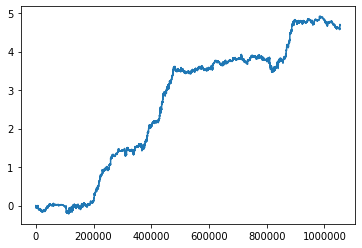

In [39]:
mcda = MCDA(btc, 150)
mcda.run_backtest()
mcda.show_performace()